In [1]:
gpu_use = TRUE

library(reticulate, quietly = TRUE)

if (gpu_use){
    device <- 'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device <- NULL
}

In [111]:
suppressPackageStartupMessages({
    library(splatter)
    
    library(scater)
    library(scran)
    library(bluster)
    
    library(stringr)
    library(ggpubr, quietly = T)
    
    library(plyr, quietly = T)
    library(reshape2, quietly = T)
    
    library(StabEco, quietly = T)
    library(igraph, quietly = T)
    
    library(liana, quietly = T)
    library(tibble, quietly = T)
    library(reticulate, quietly = T)
    c2c <- reticulate::import(module = "cell2cell", as="c2c")
    
    library(ggplot2, quietly = T)

})
source('../simulation_functions.r')

In [ ]:
seed <- 888
set.seed(seed)
n.cores <- 48

env.name<-'tc2c_benchmark'
data.path<-'/data/hratch/ccc_protocols/'


return_all = TRUE

# Functions

In [112]:
random.omit<-function(sim, md.group.label, frac, seed = 888){
    md.group<-unique(sim[[md.group.label]])
    n.md.group<-length(md.group)
    set.seed(seed)
    omit.md.group = sort(as.character(sample(md.group, size = frac*n.md.group, replace = FALSE)))
    
    return(omit.md.group)
}  

# get all unique elements in each tensor dimension
get.tensor.elements<-function(scores.list){
    senders<-unique(sort(unique(unname(unlist(sapply(scores.list, function (context.score) unique(context.score$source)))))))
    receivers<-unique(sort(unique(unname(unlist(sapply(scores.list, function (context.score) unique(context.score$target)))))))
    LRs<-unique(sort(unique(unname(unlist(sapply(scores.list, function (context.score) unique(paste0(context.score$ligand, '&', context.score$receptor))))))))
    contexts<-unique(sort(unique(names(scores.list))))
    return(list(senders = senders, receivers = receivers, LRs = LRs, contexts = contexts))
}

# Simulation

Note, we set the `return_all` parameter to True since any missing values that were not explicitly simulated to be missing are true biological 0s.

Simulation parameters:

In [130]:
base_params <- newSplatParams()
n.cells<-5e3
n.cell.types<-6
n.genes<-2e3
n.lrs<-2e2

n.contexts<-5 # of contexts

sim_params <- setParams(
    base_params,
    seed = seed,
    nGenes = n.genes,
    
    # batches - introduce mild ones to have context-driven changes since will treat batch as context
    batchCells = rep(n.cells/n.contexts, n.contexts),
    batch.rmEffect = FALSE, 
    batch.facLoc = 0.125, # higher values increase batch severity
    batch.facScale = 0.125, # higher values increase batch severity
    # cell types
    group.prob = rep(1/n.cell.types, n.cell.types), 
    de.facLoc = 0.3, # increase separation between cell types
    de.facScale = 0.6 # increase separation between cell types
)

In [131]:
# create the gold standard dataset
sim.gold<-splatSimulateGroups(sim_params, verbose = F)

# run basic qc 
sim.gold<-qc.data(sim.gold)

The cell counts are as follows:

In [132]:
df<-data.frame(colData(sim.gold))
cell.counts<-ddply(df, .(df$Batch, df$Group), nrow)
reshape2::dcast(df, Batch ~ Group)

Using Discard as value column: use value.var to override.

Aggregation function missing: defaulting to length



Batch,Group1,Group2,Group3,Group4,Group5,Group6
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Batch1,159,147,165,176,147,176
Batch2,150,140,179,172,151,167
Batch3,173,160,162,165,149,161
Batch4,153,151,161,175,147,161
Batch5,145,161,163,170,159,171


In [144]:
# sim.gold.viz<-sim.gold

# sim.gold.viz <- scater::logNormCounts(sim.gold.viz)
# # sim.gold.viz <- scran::fixedPCA(sim.gold.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs
# sim.gold.viz <- scater::runPCA(sim.gold.viz, exprs_values = 'logcounts', scale = T, ntop = dim(sim.gold.viz)[[1]]) 

# sim.gold.viz <- scater::runUMAP(sim.gold.viz, pca = 50)

# h_ = 7
# w_ = 15
# options(repr.plot.height=h_, repr.plot.width=w_)

# g1a<-plotPCA(sim.gold.viz, colour_by = "Group")
# g1b<-plotPCA(sim.gold.viz, colour_by = "Batch")
# g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
# g1

# h_ = 7
# w_ = 15
# options(repr.plot.height=h_, repr.plot.width=w_)

# g1a<-plotUMAP(sim.gold.viz, colour_by = "Group")
# g1b<-plotUMAP(sim.gold.viz, colour_by = "Batch")

# g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
# g1

In [159]:
sim.gold.viz<-sim.gold

sim.gold.viz <- scater::logNormCounts(sim.gold.viz)
# sim.gold.viz <- scran::fixedPCA(sim.gold.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs
sim.gold.viz <- scater::runPCA(sim.gold.viz, exprs_values = 'logcounts', scale = F, ntop = dim(sim.gold.viz)[[1]]) 
sim.gold.viz <- scater::runUMAP(sim.gold.viz, pca = 50)

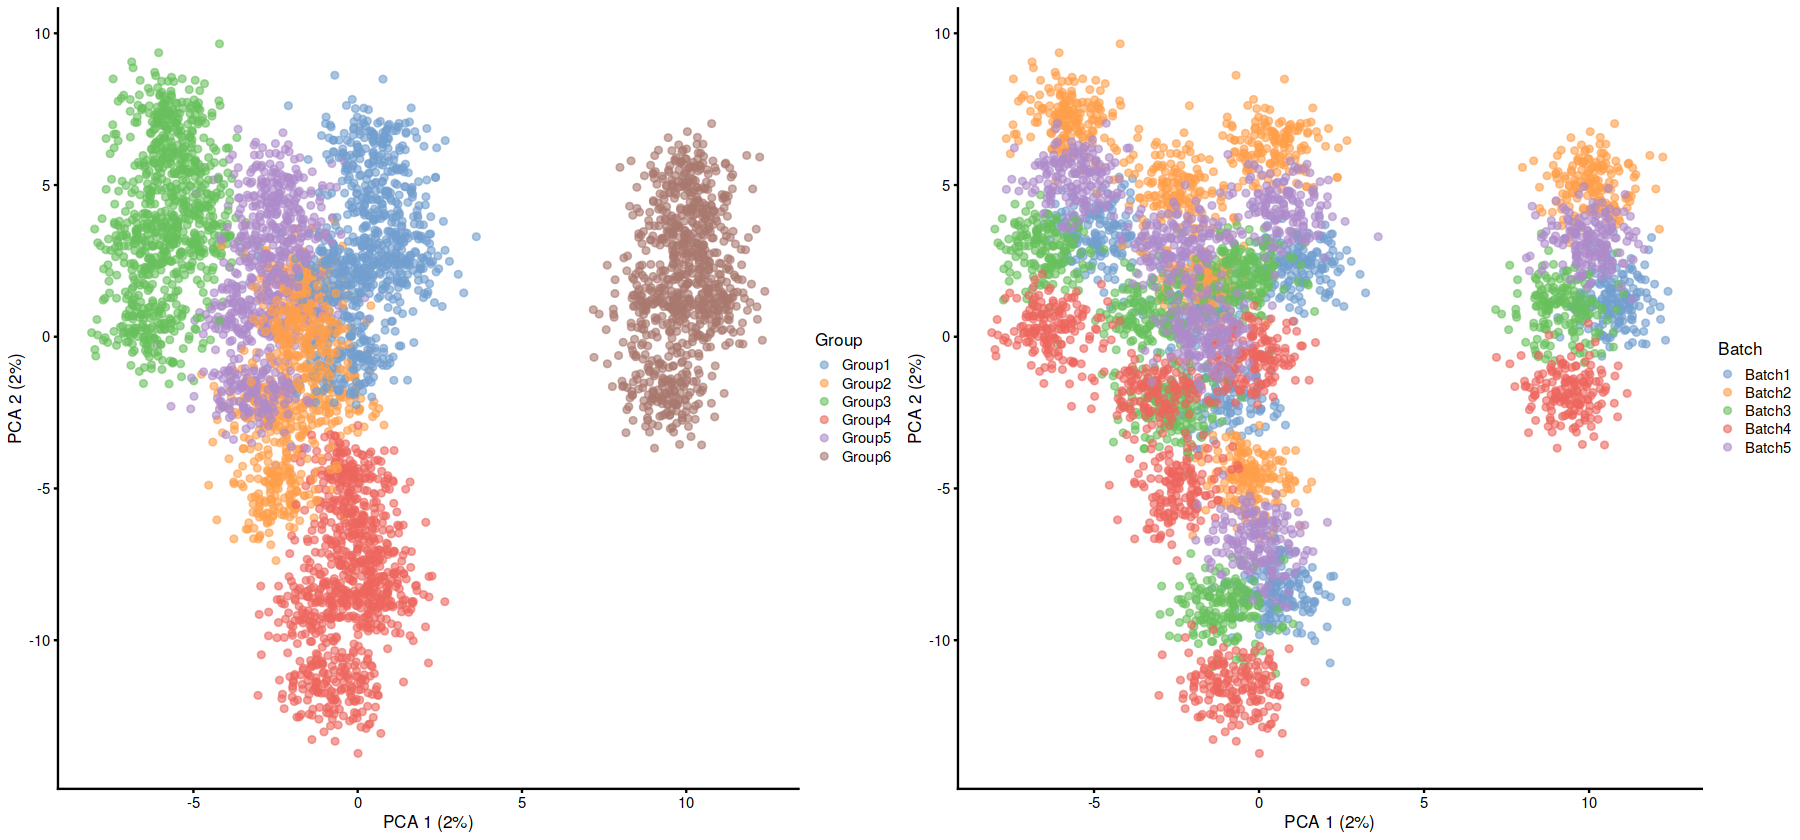

In [160]:
h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(sim.gold.viz, colour_by = "Group")
g1b<-plotPCA(sim.gold.viz, colour_by = "Batch")
g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'missing_vals_pca', ext), g1, 
                                             height = h_, width = w_)}
g1

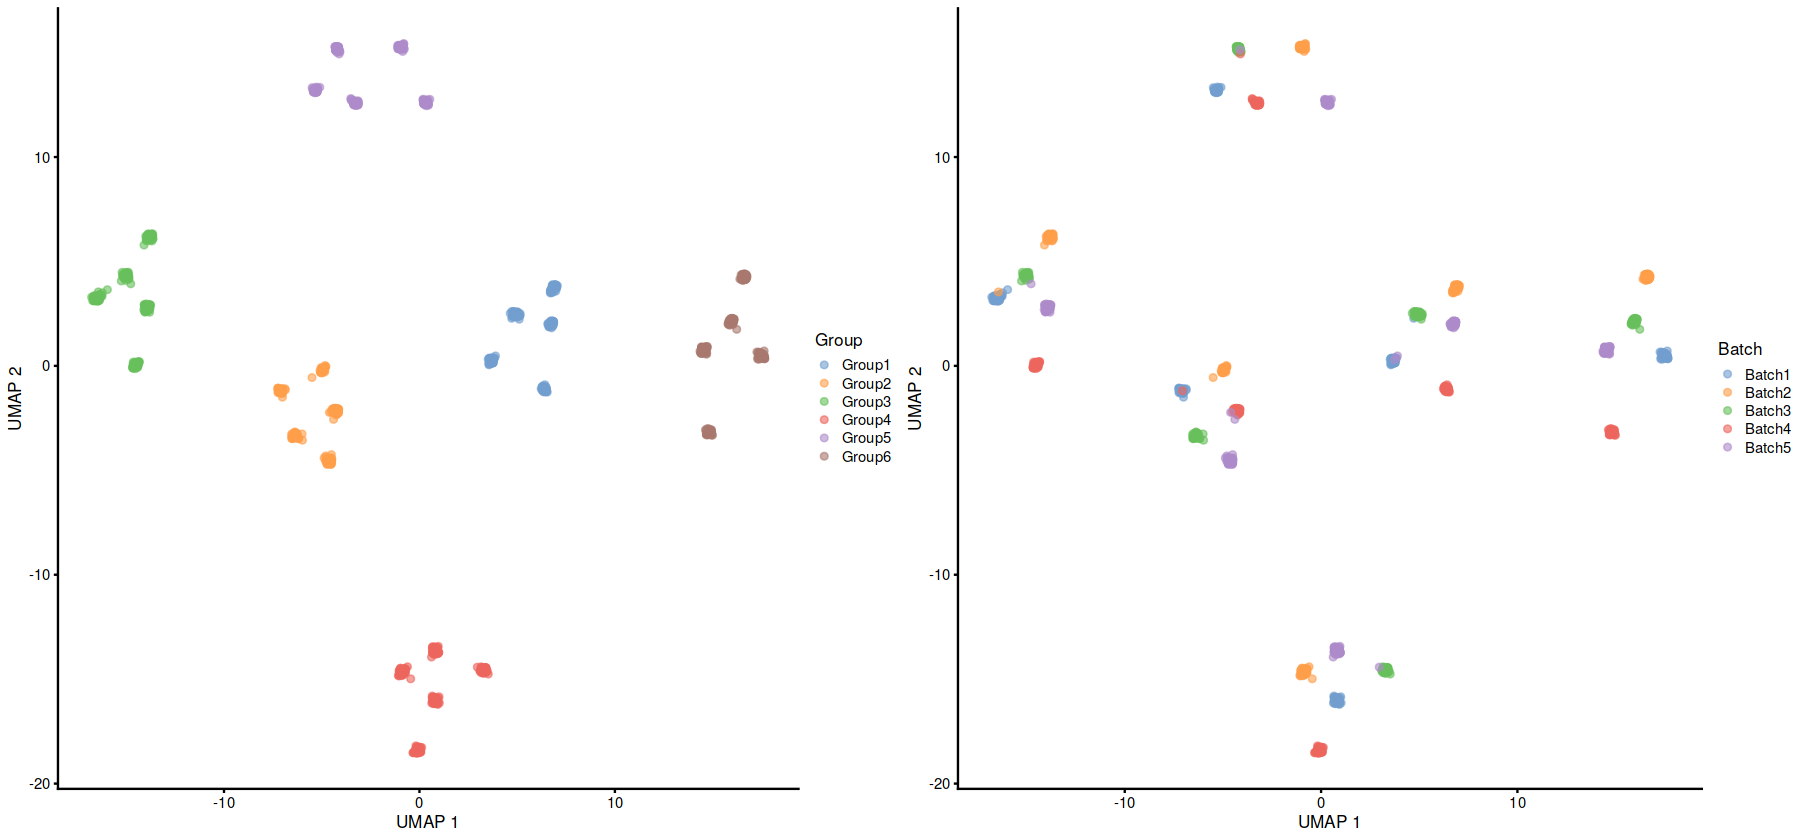

In [161]:
g2a<-plotUMAP(sim.gold.viz, colour_by = "Group", jitter = F)
g2b<-plotUMAP(sim.gold.viz, colour_by = "Batch", jitter = F)

g2<-ggpubr::ggarrange(g2a, g2b, ncol = 2)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'missing_vals_umap', ext), g2, 
                                             height = h_, width = w_)}
g2

Gold standard CCC tensor with no omitted cell types or LR pairs:

In [128]:
# generate a LR PPI on a subset of the genes
set.seed(seed)
lr.genes<-sort(as.character(sample(rownames(sim.gold), size = n.lrs, replace = FALSE)))
lr.ppi<-generate.lr.ppi(lr.genes)
interacting.lr.genes<-unique(c(lr.ppi$source_genesymbol, lr.ppi$target_genesymbol))

#####

# split by context -- needed for LR omission
sim.gold.list<-split.by.context(sim.gold) 

# log-normalize
sim.gold.list<-lapply(sim.gold.list, FUN = function(sce) {
    sce <- scater::logNormCounts(sce)
})

# score communication
scores.gold<-list()
for (context in names(sim.gold.list)){
    scores.gold[[context]]<-score.communication(sce_ = sim.gold.list[[context]], 
                                   method = c('cellphonedb', 'natmi', 'sca'), # only the ones with a magnitude score
                                   idents_col = 'Group', 
                                   assay.type = 'logcounts',
                                   return_all = return_all, 
                                   expr_prop = 0.05, 
                                   seed = seed,
                                   parallelize = T, 
                                   workers = n.cores, 
                                   permutation.params = list(nperms = 1), # since we don't use p-values
                                   resource = 'custom',
                                   external_resource = lr.ppi)
}

# this could possibly happen, in which case the zeros filling in needs to be done always
if (return_all){
    if (length(unique(sapply(scores.gold, function(x) dim(x)[[1]]))) != 1){
        stop("Unexpected # of interactions b/w samples despite 'return_all' being TRUE")
    } 
}

tensor.gold.elements<-get.tensor.elements(scores.gold)

# tensor building and decomposition could be one step if going to use return_all = T
tensor.gold<-liana_tensor_c2c(context_df_dict = scores.gold,
                               score_col = 'score',
                               ligand_col = 'ligand', 
                               receptor_col = 'receptor', 
                               lr_fill = NaN, 
                               cell_fill = NaN,
                               how = 'outer',
                               seed = seed, 
                               conda_env = env.name,
                               device = NULL,
                               build_only = T)

if (!return_all){
     # get the values that are masked in the gold standard, if they weren' filled in by return_all parameter
    # these are true zeros which will be used for cheking the fill in the omitted tensors that have masks
    zeros.gold<-which(tensor.gold$mask == 0, arr.ind = T)
}

if (gpu_use){
    tensorly$set_backend('pytorch')
    tensor.gold$to_device('cuda')
}       

if (!return_all){
    # remove the masked indices so that they are treated as 0 
    # (this is like having set lr_fill and cell_fill above to 0)
    mask<-tensor.gold$mask
    mask[mask == 0] = 1
    tensor.gold$mask<-mask
}

# identify the rank and run the decomposition
tensor.gold<-liana::decompose_tensor(tensor = tensor.gold,
                                       rank = NULL, 
                                       tf_optimization = 'regular', 
                                       seed = seed, 
                                       upper_rank = 25, 
                                       init = 'svd', 
                                       factors_only = F, 
                                       ) # estimate the rank by setting to NULL
print(paste0('The rank for the gold standard tensor is ', tensor.gold$rank))
if (gpu_use)({tensorly$set_backend('numpy')}) # need to change back to be able to manipulate masks, etc

Visualize:

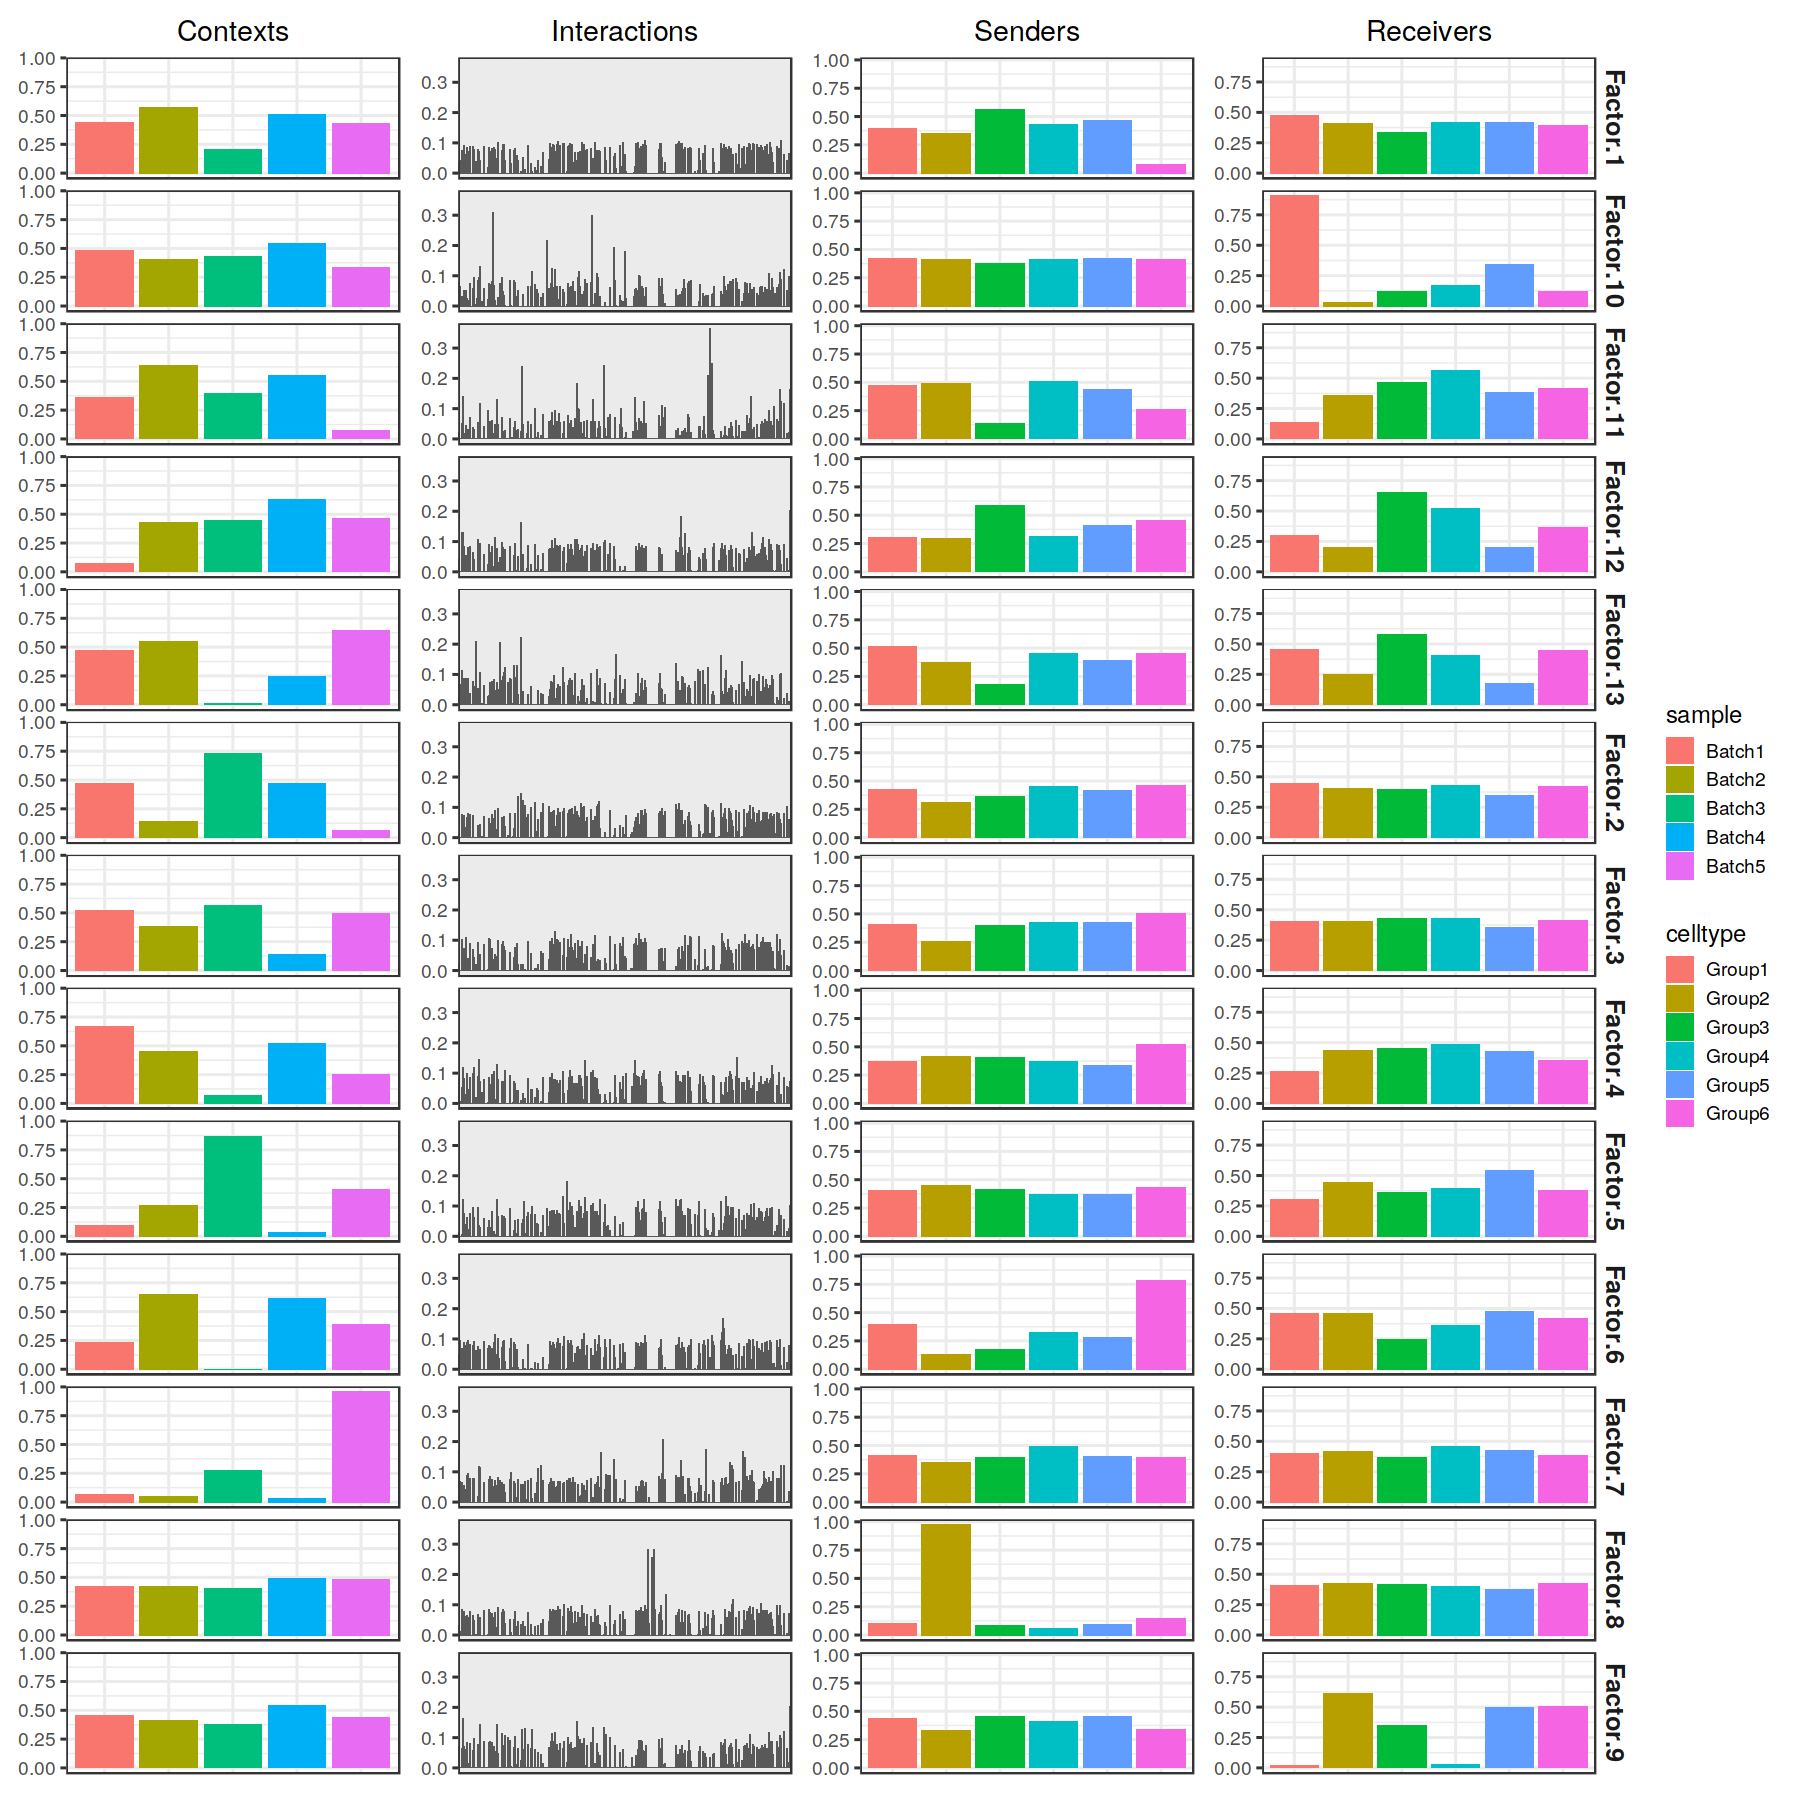

In [118]:
h_ = 15
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

sim.gold.viz<-sim.gold
sim.gold.viz@colData[['sample']]<-sim.gold.viz@colData$Batch
sim.gold.viz@metadata$tensor_res<-liana:::format_c2c_factors(tensor.gold$factors)
plot_c2c_overview(sim.gold.viz, sample_col = 'Batch', group_col = 'sample')

## Set up Iterable Parameters

In [119]:
# fraction of .* to omit
frac.contexts = seq(0.2, 0.6, 0.2) # fraction of contexts to omit cell types
frac.cts = seq(1/6, 2/3, 1/6)
frac.lrs = seq(0.1, 0.6, 0.2)

# same or different .* to omit across contexts -- true/same is more difficult problem
consistent.remove.cts = c(TRUE, FALSE) 
consistent.remove.lrs = c(TRUE, FALSE)

The fraction and actual number of cell types to be ommitted is:

In [120]:
frac.contexts
frac.contexts*n.contexts

[1] 0.2 0.4 0.6

[1] 1 2 3

The fraction and actual number of cell types to be ommitted is:

In [121]:
frac.cts
frac.cts*n.cell.types

[1] 0.1666667 0.3333333 0.5000000 0.6666667

[1] 1 2 3 4

The fraction and actual number of LRs to be ommitted is:

In [122]:
frac.lrs
frac.lrs*length(interacting.lr.genes)

[1] 0.1 0.3 0.5

[1] 13 39 65

In [123]:
iter.params.list<-list()
counter<-1
for (frac.ct in frac.cts){
    for (frac.lr in frac.lrs){
        for (frac.context in frac.contexts){
            for (cr.ct in consistent.remove.cts){
                for (cr.lr in consistent.remove.lrs){
                    iter.params.list[[counter]]<-list(frac.ct = frac.ct, frac.lr = frac.lr, 
                                                      frac.context = frac.context, cr.ct = cr.ct, cr.lr = cr.lr)
                    counter<-counter + 1
                }
            }
        }
    }
}

## Iterate

In [124]:
print(paste0('The number of iterations is: ', length(iter.params.list)))

[1] "The number of iterations is: 144"


In [125]:
res.df <- data.frame(matrix(ncol = 11, nrow = 0))
res.col.names<-c('iteration', 'celltype.fraction', 'lr.fraction', 'context.fraction', 'celltype.consistent', 
                 'lr.consistent', 'missing.fraction', 'corrindex.masked', 'corrindex.zeros')
colnames(res.df)<-res.col.names

seed.iter<-1
iter<-1

In [129]:
print('Begin iteration: ')
for (iter.params in iter.params.list){
    try({

        print(paste0('Iteration no.: ', iter))
        # select contexts, cell types, and LRs to omit-------------------------------------------------------------
        omit.contexts.ct <- random.omit(sim = sim.gold, md.group.label = 'Batch', frac = iter.params$frac.context, seed = seed.iter)
        seed.iter<-seed.iter + 1
        omit.contexts.lr <- random.omit(sim = sim.gold, md.group.label = 'Batch', frac = iter.params$frac.context, seed = seed.iter)
        seed.iter<-seed.iter + 1

        omit.cts <- list()
        if (iter.params$cr.ct){
            ocs <- random.omit(sim = sim.gold, md.group.label = 'Group', frac = iter.params$frac.ct, seed = seed.iter)
            seed.iter<-seed.iter + 1
            for (oc in omit.contexts.ct){
                omit.cts[[oc]] = ocs
            }
        }else{
            for (oc in omit.contexts.ct){
                omit.cts[[oc]] = random.omit(sim = sim.gold, md.group.label = 'Group', frac = iter.params$frac.ct, seed = seed.iter)
                seed.iter<-seed.iter + 1
            }
        }

        omit.lrs <- list()
        if (iter.params$cr.lr){
            set.seed(seed.iter)
            olrs<-sort(as.character(sample(interacting.lr.genes, size = iter.params$frac.lr*length(interacting.lr.genes), replace = FALSE)))
            seed.iter<-seed.iter + 1
            for (oc in omit.contexts.lr){
                omit.lrs[[oc]] = olrs
            }
        }else{
            for (oc in omit.contexts.lr){
                set.seed(seed.iter)
                olrs<-as.character(sample(interacting.lr.genes, size = iter.params$frac.lr*length(interacting.lr.genes), replace = FALSE))
                omit.lrs[[oc]] = olrs
                seed.iter<-seed.iter + 1
            }
        }
        # ----------------------------------------------------------------------------------------------------------
        set.seed(seed) # reset to main

        # apply the omissions
        sim.omit.list<-sim.gold.list

        for (context in names(omit.cts)){
            sce.omit <- sim.omit.list[[context]]
            cell.types.omit = omit.cts[[context]]
            barcodes.keep = rownames(colData(sce.omit)[!(colData(sce.omit)$Group %in% cell.types.omit),])
            sim.omit.list[[context]] <- sce.omit[, barcodes.keep]
        }


        for (context in names(omit.lrs)){
            sce.omit<-sim.omit.list[[context]]
            sim.omit.list[[context]]<-sce.omit[!(rownames(sce.omit) %in% omit.lrs[[context]]), ]
        }

        # get the communication scores------------------------------------------------------------------------------
        # only re-calculate scores on altered contexts to save computation time

        changed.contexts<-sort(unique(c(omit.contexts.ct, omit.contexts.lr)))
        scores.omit<-scores.gold

        for (context in changed.contexts){
            scores.omit[[context]]<-score.communication(sce_ = sim.omit.list[[context]], 
                                           method = c('cellphonedb', 'natmi', 'sca'), # only the ones with a magnitude score
                                           idents_col = 'Group', 
                                           assay.type = 'logcounts',
                                           return_all = return_all, 
                                           expr_prop = 0.05, 
                                           seed = seed,
                                           parallelize = T, 
                                           workers = n.cores, 
                                           permutation.params = list(nperms = 1), # since we don't use p-values
                                           resource = 'custom',
                                           external_resource = lr.ppi)
        }
        
                            
        # this will restore LR pairs that were completely removed during omitting process
        # happens bc they are not present in all contexts, so if removed in some contexts, may completely dissapear
        # making tensor dimensions different and corrindex calulation impossible
        # improve: should directly insert into tensor; right now using hacky way where adding the missing LRs
        # to any of the sample communication matrices will automatically add it to the constructed tensor
        tensor.omit.elements<-get.tensor.elements(scores.omit)

        for (element.type in names(tensor.omit.elements)){
            elements.gold<-tensor.gold.elements[[element.type]]
            elements.omit<-tensor.omit.elements[[element.type]]
            if (length(elements.omit) < length(elements.gold)){
                if (element.type != 'LRs'){stop('Need to account for non-LR missing elements')}
                elements.missing<-setdiff(elements.gold, elements.omit)
                # inserting missing LRs with a NaN score should make the tensor dimensions consistent
                # this will add a mask for these missing lrs
                for(em in elements.missing){
                    context.score<-scores.omit[[1]]
                    to.add<-context.score[1, ]
                    to.add[['score']]<-NaN
                    lr.missing<-stringr::str_split(em, pattern='&')[[1]]
                    to.add[['ligand']]<-lr.missing[[1]]
                    to.add[['receptor']]<-lr.missing[[2]]
                    scores.omit[[1]]<-rbind(context.score, to.add)

                }
            }
        }                   
                            
        # run tensor-c2c and get the corrindex for each score type
        suppressMessages({
            suppressWarnings({
                # build
                tensor<-liana_tensor_c2c(context_df_dict = scores.omit,
                                                           score_col = 'score',
                                                           ligand_col = 'ligand', 
                                                           receptor_col = 'receptor', 
                                                           how = 'outer',
                                                           seed = 888, 
                                                           init = 'svd', 
                                                           conda_env = env.name,
                                                           device = NULL,
                                                           lr_fill = NaN, 
                                                           cell_fill = NaN,
                                                           build_only = T)
                if (!return_all){
                    # mask
                    # if return_all is F masking will also add masks to values that were true 0 in the gold-standard but that 
                    # would have been masked using the lr_fill/cell_fill because of the structure of the dataset (i.e., the zero.gold)
                    # here, we determine whether this case should be actually masked (because we deliberately omitted something)
                    # or whether they should not be masked (because we did not deliberately omit it, but it received a mask due to the dataset structure)
                    masked.omit<-which(tensor$mask == 0, arr.ind = T)
                    masked.overlap.idxs<-match(do.call(paste, data.frame(zeros.gold)), 
                                              do.call(paste, data.frame(masked.omit)))
                    if (length(masked.overlap.idxs) != dim(zeros.gold)[[1]]){
                        stop('The gold standard masked values should be a subset of the omitted tensor masked values')
                    }

                    masked.overlap.idx<-masked.overlap.idxs[[1]]
                    zeros.omit.idx<-c()
                    for (masked.overlap.idx in masked.overlap.idxs){
                        masked.overlap<-lapply(1:4, function(i) tensor$order_names[[i]][masked.omit[masked.overlap.idx,][[i]]])
                        masked.overlap[[2]]<-stringr::str_split(masked.overlap[[2]], pattern="\\^")[[1]]
                        masked.overlap[[3]]<-unique(c(masked.overlap[[3]], masked.overlap[[4]]))

                        masked.contexts<-unique(c(omit.contexts.ct, omit.contexts.lr))

                        masked = F
                        # if (masked.overlap[[1]] %in% omit.contexts.ct){
                        if (length(intersect(masked.overlap[[3]], omit.cts[[masked.overlap[[1]]]])) > 0){
                            masked = T
                        }

                        if (length(intersect(masked.overlap[[2]], omit.lrs[[masked.overlap[[1]]]]) > 0)){
                            masked = T
                        }

                        # still a true zero, only had NaN filled in because tensor building unaware of gold-standard
                        if (!masked){
                            zeros.omit.idx<-c(zeros.omit.idx, masked.overlap.idx)
                        }

                    }
                    # do not mask values that are still true 0s
                    zeros.omit<-masked.omit[zeros.omit.idx, ]
                    tensor$mask[zeros.omit]<-1
                }

                frac.missing<-length(which(tensor$mask == 0))/length(tensor$mask)

                # prepare the tensor that will be filled with zeros
                # don't need to rebuild because missing values are actually filled with 0, but just masked
                # so this is essentialy doing the same thing as running the build with lr_fill = 0 and cell_fill = 0
                tensor.zeros<-tensor$copy()
                tensor.zeros$mask[tensor.zeros$mask == 0] = 1                                

                # now run the decomposition
                if (gpu_use){
                    tensorly$set_backend('pytorch')
                    tensor$to_device('cuda')
                    tensor.zeros$to_device('cuda')
                }

                tensor<-liana::decompose_tensor(tensor = tensor,
                                               rank = tensor.gold$rank, 
                                               tf_optimization = 'regular', 
                                               seed = seed, 
                                               init = 'svd', 
                                               factors_only = F, 
                                               ) # estimate the rank by setting to NULL
                tensor.zeros<-liana::decompose_tensor(tensor = tensor.zeros,
                                                   rank = tensor.gold$rank, 
                                                   tf_optimization = 'regular', 
                                                   seed = seed, 
                                                   init = 'svd', 
                                                   factors_only = F, 
                                                   ) # estimate the rank by setting to NULL
                if (gpu_use)({tensorly$set_backend('numpy')}) # need to change back to be able to manipulate masks, etc


                # calculate corrindex
                corr.index = list()
                corr.index[['masked']]<- (1 - (c2c$tensor$metrics$correlation_index(tensor.gold$factors,tensor$factors)))
                corr.index[['zeros']]<- (1 - (c2c$tensor$metrics$correlation_index(tensor.gold$factors, tensor.zeros$factors)))
            })
        })

        res<-c(iter, unname(unlist(iter.params)), frac.missing, corr.index$masked, corr.index$zeros)
        names(res)<-res.col.names
        res.df<-rbind(res.df, t(as.data.frame(res)))

        write.csv(res.df, paste0(data.path, 'interim/', 'missing_vals_benchmark.csv'))
    })
    iter<-iter + 1
}
print('complete')